### In this notebook I will do the following:

* Run several experiments to train the SetFit Transformer (fine-tuned ST) and a simple LogisticRegression without fine-tuning the pre-trained embeddings across different datasets, nr of training examples and training seeds in order to have reliable results.
* Compare the performance across different datasets and nr of trainig examples.

* Import the libraries

In [187]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from tqdm import tqdm
import seaborn as sns
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_functions import get_data, get_embedding, preprocess_ade_sent
from sklearn.manifold import TSNE

* To achieve more reliable results lets train SetFit using different models, different datasets and different seeds. For each model and dataset we are going to average the accuracy among the seeds.

In [1]:
# SetFit - Random Sampling
def train_setfit(model_name, train_data, eval_data, num_iterations=20, column_mapping=None): 
    """
        Fine-Tuning of SetFit
    """
    model = SetFitModel.from_pretrained(model_name)

  # Create trainer
    trainer = SetFitTrainer(
          model=model,
          train_dataset=train_data,
          eval_dataset=eval_data,
          loss_class=CosineSimilarityLoss,
          batch_size=16,
          num_iterations=num_iterations, # Number of text pairs to generate for contrastive learning
          num_epochs=1, # Number of epochs to use for contrastive learning,
          column_mapping=column_mapping
      )

    trainer.train()
    metrics = trainer.evaluate()
    return trainer, metrics['accuracy']

In [154]:
def logreg_train(df_dic, embedding_model_name):
    """
    Train a Logistic Regression using the pretrained sentence embeddings and our labels
    """

    def generate_embeddings(data, embedding_model):
        """
            Generate the pretrained embeddings using a SentenceTransformer model
        """
        new_df = data.map(lambda example: {'embedding' : get_embedding(embedding_model, example['text'])})
        return np.array(new_df['embedding']), np.array(new_df['label'])

    X_train, y_train = generate_embeddings(df_dic['train'], embedding_model_name)
    X_eval, y_eval = generate_embeddings(df_dic['eval'], embedding_model_name)
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    return lr, accuracy_score(y_eval, lr.predict(X_eval))

In [156]:
def run_experiments(seeds, dataset_dic, nr_ex_class, finetune):  
    """
        Run all experiments across different parameters 
    """
    
    cols = ['dataset_name', 'nr_ex_per_class' ,'seed', 'model', 'accuracy']
    result_df = pd.DataFrame()
    model_name = 'all-mpnet-base-v2'
    
    for dataset_name in tqdm(dataset_dic):
        for nr in nr_ex_class:
            for seed in seeds: 
                train_df, test_df = get_data(dataset_dic[dataset_name], seed=seed, nr_example_per_class=nr)

                if finetune:
                    trainer, acc_score = train_setfit('sentence-transformers/' + model_name, train_df, test_df, 20)
                else:
                    df_dic = {'train' : train_df, 'eval' : test_df}
                    trainer, acc_score = logreg_train(df_dic, model_name)

                row_data = [dataset_name, nr ,seed, trainer, acc_score]
                row_dic = {el1:[el2] for el1, el2 in zip(cols, row_data)}
                result_df = pd.concat([result_df, pd.DataFrame.from_dict(row_dic)], ignore_index=True)

    return result_df

* Let's create the datasets, determine the ST models we want to utilize, select various seeds, and determine the number of examples we'll include in our experiments.

In [ ]:
ade_df = load_dataset('SetFit/ade_corpus_v2_classification')
sent_df = load_dataset('SetFit/SentEval-CR')
ade_df, sent_df = preprocess_ade_sent(ade_df, sent_df)
sst2_df = load_dataset('SetFit/sst2')

dataset_dic = {'SST2' : sst2_df, 
               'ADE' : ade_df,
              'SENT' : sent_df}


seeds = [10, 20, 30, 40, 50]
nr_ex_class = [18, 50]

* Run all experiments by fine-tuning the embeddings of ST


In [159]:
result_df_finetune = run_experiments(seeds=seeds, dataset_dic=dataset_dic, nr_ex_class=nr_ex_class, finetune=True)

* Run all experiments by using the pre-trained embeddings of ST


In [163]:
result_df_nofinetune = run_experiments(seeds=seeds, dataset_dic=dataset_dic, nr_ex_class=nr_ex_class, finetune=False)

* Export the result dataframes into csv file


In [168]:
result_df_nofinetune.to_csv('Results_DF/result_df_nofinetune.csv', index=False)
result_df_finetune.to_csv('Results_DF/result_df_finetune.csv', index=False)

* Define some functions which will be used to visualize the results.

In [170]:
def result_tabular(col_name):
    """
        Plot the results in tabular format
    """
    temp1_ft = result_df_finetune.groupby([col_name])['accuracy'].mean().reset_index().set_index(col_name)
    temp1_noft = result_df_nofinetune.groupby([col_name])['accuracy'].mean().reset_index().set_index(col_name)
    temp1_ft.columns = ['Fine-Tune']
    temp1_noft.columns = ['No Fine-Tune']
    return pd.concat([temp1_ft, temp1_noft], axis=1)


def result_visualization(col_name):
    """
        Plot the results using visualizations
    """
    
    temp1_ft = result_df_finetune.groupby([col_name])['accuracy'].mean().reset_index().set_index(col_name)
    temp1_noft = result_df_nofinetune.groupby([col_name])['accuracy'].mean().reset_index().set_index(col_name)
    temp1_ft.columns = ['Fine-Tune']
    temp1_noft.columns = ['No Fine-Tune']

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,4), sharey=True)

    sns.barplot(x=temp1_ft.index, y=temp1_ft['Fine-Tune'], ax=axs[0])
    # Add the values on top of the bars
    for i, v in enumerate(temp1_ft['Fine-Tune']):
        axs[0].text(i, round(v, 2) + 0.000001, str(round(v, 2)), ha='center')
        
    sns.barplot(x=temp1_noft.index, y=temp1_noft['No Fine-Tune'], ax=axs[1])
    # Add the values on top of the bars
    for i, v in enumerate(temp1_noft['No Fine-Tune']):
        axs[1].text(i, round(v, 2) + 0.000001, str(round(v, 2)), ha='center')
    
    
  
    axs[0].set_title('Fine-Tune')
    axs[1].set_title('No Fine-Tune')
    #axs[2].set_ylabel('Standard Fine-Tune')
    axs[0].set_ylabel('Accuracy')
    axs[1].set_ylabel('')
    #axs[2].set_ylabel('')

* Compare the average performance (average accuracy) of SetFit with Fine-Tuning embeddings, SetFit without Fine-Tuning the embeddings, Standard Fine-Tuning and GPT-3 on few-shot learning across different datasets, training seeds and number of examples.

In [171]:
nofinetune_mean = result_df_nofinetune['accuracy'].mean()
finetune_mean = result_df_finetune['accuracy'].mean()
pd.DataFrame({'Fine-Tune' : [finetune_mean],
              'No Fine-Tune' : [nofinetune_mean]})

,Fine-Tune,No Fine-Tune
0,0.695749,0.657111


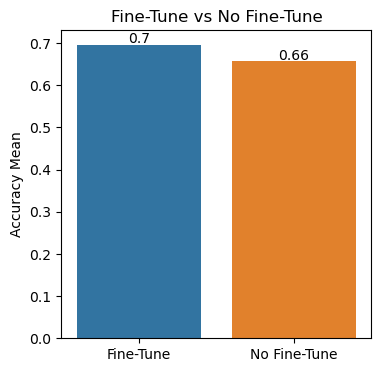

In [181]:
plt.figure(figsize=(4,4))
sns.barplot(y=[finetune_mean, nofinetune_mean], x=['Fine-Tune', 'No Fine-Tune'])

# Add the values on top of the bars
for i, v in enumerate([finetune_mean, nofinetune_mean]):
    plt.text(i, round(v, 2) + 0.00001, str(round(v, 2)), ha='center')


plt.ylabel('Accuracy Mean')
plt.title('Fine-Tune vs No Fine-Tune')
plt.savefig('Plot_Results/FineTune_vs_NoFineTune.jpg')

* Compare the average performance (average accuracy) of SetFit with Fine-Tuning embeddings, SetFit without Fine-Tuning the embeddings and Standard Fine-Tuning .

In [173]:
# Plot the model performances using tabular data.

result_tabular('dataset_name')

,Fine-Tune,No Fine-Tune
dataset_name,,
ADE,0.813133,0.746100
SENT,0.377025,0.380478
SST2,0.897090,0.844756


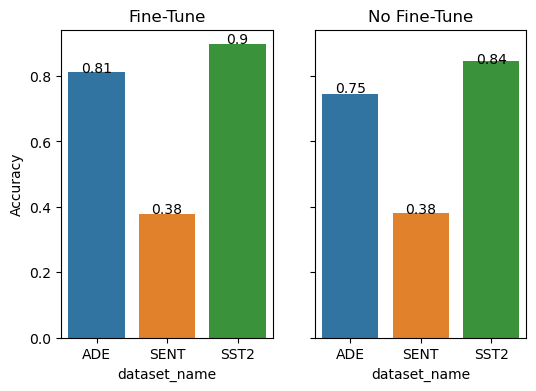

In [177]:
# Plot the model performances using visualizations.
result_visualization('dataset_name')
plt.savefig('Plot_Results/datasets.jpg')

* Compare the average performance (average accuracy) of SetFit with Fine-Tuning embeddings, SetFit without Fine-Tuning the embeddings, Standard Fine-Tuning and GPT-3 on few-shot learning across different number of exampled that were selected to fine-tune the models.

In [178]:
result_tabular('nr_ex_per_class')

,Fine-Tune,No Fine-Tune
nr_ex_per_class,,
18,0.686357,0.643121
50,0.705141,0.671102


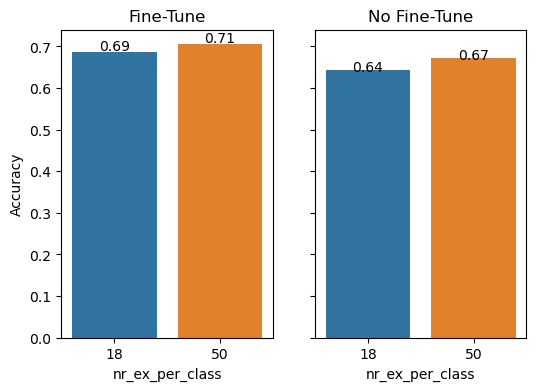

In [179]:
result_visualization('nr_ex_per_class')
plt.savefig('Plot_Results/nr_examples.jpg')

* Since especially for the SENT dataset the performance is quite low, let's plot the pre-trained and fine-tuned embeddings of the test set.

In [226]:
def plot(dataset_name, test_embeddings_nofinetune, test_embeddings_finetune, test_labels):
    
    plt.figure(figsize=(20,10))
    test_embeddings_tsne_nofinetune = TSNE(n_components=2, random_state=42).fit_transform(test_embeddings_nofinetune)
    plt.subplot(221)
    plt.title(f'{dataset_name} X_test No Fine-Tune')
    for i, t in enumerate(set(test_labels)):
      idx = test_labels == t
      plt.scatter(test_embeddings_tsne_nofinetune[idx, 0], test_embeddings_tsne_nofinetune[idx, 1], label=t)  

    plt.legend(bbox_to_anchor=(1, 1));
    
    
    
    test_embeddings_tsne_finetune = TSNE(n_components=2, random_state=42).fit_transform(test_embeddings_finetune)
    plt.subplot(222)
    plt.title(f'{dataset_name} X_test Fine-Tune')

    for i, t in enumerate(set(np.array(test_labels))):
        idx = test_labels == t
        plt.scatter(test_embeddings_tsne_finetune[idx, 0], test_embeddings_tsne_finetune[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));


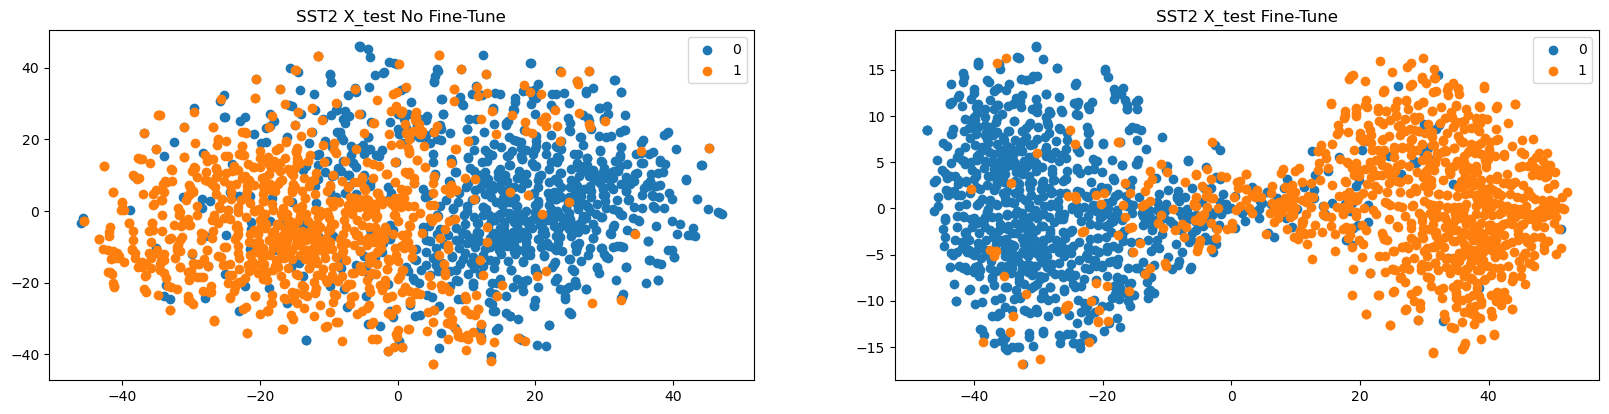

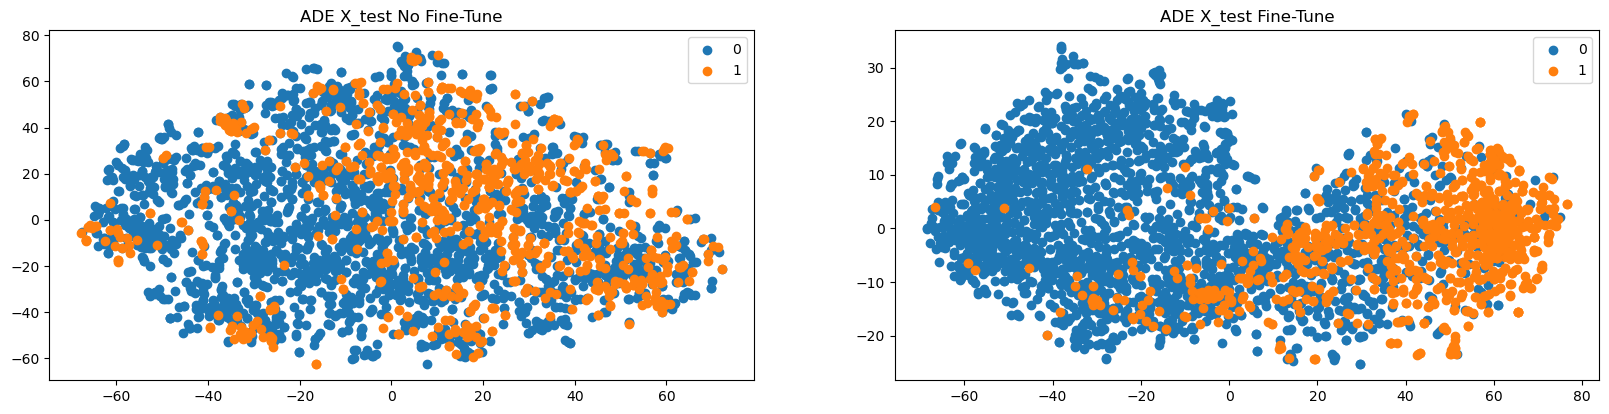

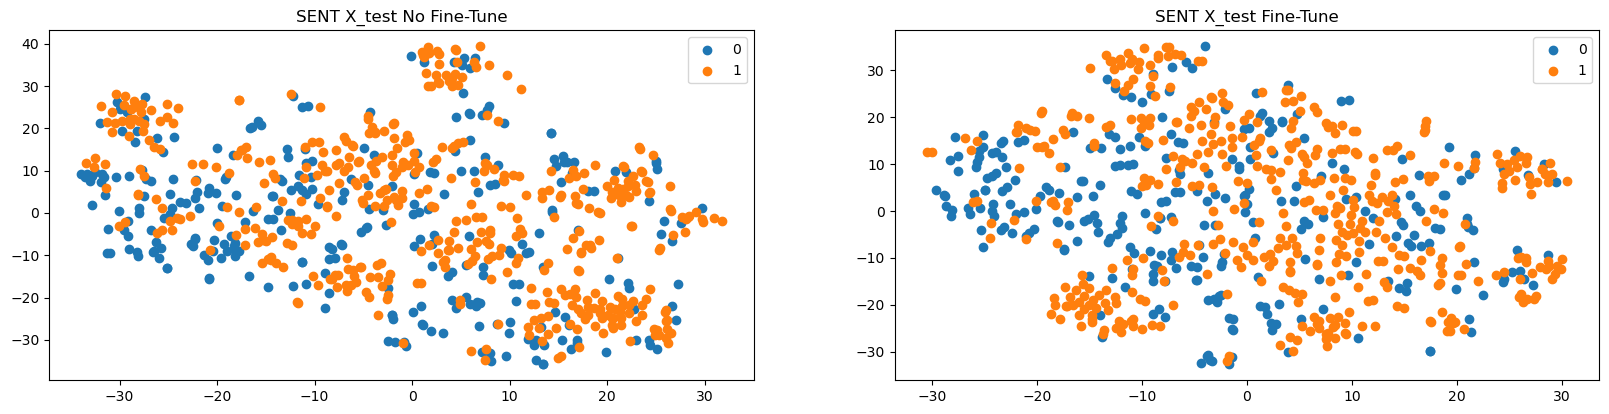

In [227]:
model_name = 'sentence-transformers/all-mpnet-base-v2'

for dataset_name in dataset_dic:
    
    test_df = dataset_dic[dataset_name]['test']
    
    test_embeddings_nofinetune = get_embedding(model_name, test_df['text'])
    
    dataset_trainer = result_df_finetune[result_df_finetune['dataset_name'] == dataset_name]['Models'].iloc[0]
    test_embeddings_finetune = dataset_trainer.model.model_body.encode(test_df['text'])
    test_labels = np.array(test_df['label'])

    plot(dataset_name, test_embeddings_nofinetune, test_embeddings_finetune, test_labels)

* As we can see, there is too much noise in the Sent dataset. After fine-tuning there is still overlap between the classes. This is the reason why the performance is so low.
* SetFit did not converge for the Sent dataset since the embeddings of the test set contain too much noise. The same applies for the pre-trained embeddings. This is the reason why the performance is so low. 